In [10]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [11]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Get Best Fit Parameters

In [12]:
# id = (133, 0, 52, 0)
# id = (133,0)
id = None
if id is None:
    with open('./../results/best_fit.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
        fit_res_dict = res_dict.copy()
elif len(id)==2:
    with open('./../results/results_ring_{:d}.pkl'.format(
            id[0]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
else:
    with open('./../results/results_ring_perturb_njob-{:d}_nrep-{:d}_ntry-{:d}.pkl'.format(
            id[0],id[1],id[2]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
prms = res_dict['prms']
eX = res_dict['best_monk_eX']
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']
K = prms['K']
SoriE = prms['SoriE']
SoriI = prms['SoriI']
SoriF = prms['SoriF']
J = prms['J']
beta = prms['beta']
gE = prms['gE']
gI = prms['gI']
hE = prms['hE']
hI = prms['hI']
L = prms['L']
CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,5*Nt,round(5*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 10000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


# Simulate Network with One vs Two Peaks

Using cpu
Generating disorder took  8.961082000000033  s



(0.0, 0.25578806921839714)

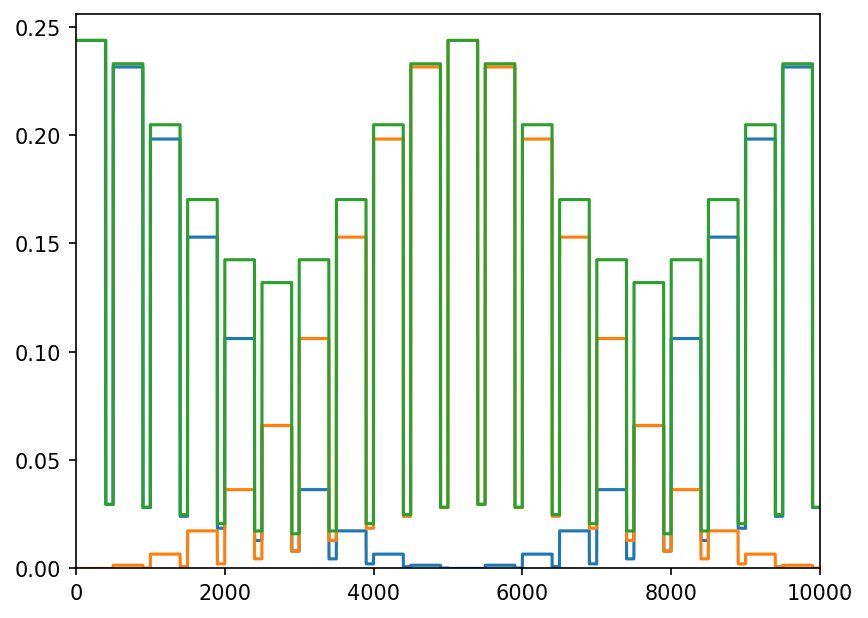

In [19]:
reload(su)

start = time.process_time()

net,M,H1,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)
H2 = np.roll(H1,N//2,0)

print("Generating disorder took ",time.process_time() - start," s")
print('')

fig,ax = plt.subplots(1,1,dpi=150)

ax.plot(H1)
ax.plot(H2)
ax.plot(H1+H2)
ax.set_xlim(0,N)
ax.set_ylim(0,None)

In [14]:
reload(su)

start = time.process_time()

net,M,H1,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)
H2 = np.roll(H1,N//2,0)

print("Generating disorder took ",time.process_time() - start," s")
print('')

# start = time.process_time()

# one_peak_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,(bX*B+aXs[-1]*H1)*eps,LAS,net.C_conds[0],mult_tau=True)
# one_peak_rates = torch.mean(one_peak_sol[:,mask_time],axis=1).cpu().numpy()
# one_peak_dynas = one_peak_sol[:,mask_time].cpu().numpy()

# np.save('one_peak_sol',one_peak_sol.cpu().numpy())

# print("Integrating one peak network took ",time.process_time() - start," s")
# print('')

# start = time.process_time()

# two_peak_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,(bX*B+aXs[-1]*(H1+H2))*eps,LAS,net.C_conds[0],mult_tau=True)
# two_peak_rates = torch.mean(two_peak_sol[:,mask_time],axis=1).cpu().numpy()
# two_peak_dynas = two_peak_sol[:,mask_time].cpu().numpy()

# np.save('two_peak_sol',two_peak_sol.cpu().numpy())

# print("Integrating two peak network took ",time.process_time() - start," s")
# print('')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
one_peak_sol = torch.from_numpy(np.load('one_peak_sol.npy')).to(device)
one_peak_rates = torch.mean(one_peak_sol[:,mask_time],axis=1).cpu().numpy()
one_peak_dynas = one_peak_sol[:,mask_time].cpu().numpy()
two_peak_sol = torch.from_numpy(np.load('two_peak_sol.npy')).to(device)
two_peak_rates = torch.mean(two_peak_sol[:,mask_time],axis=1).cpu().numpy()
two_peak_dynas = two_peak_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  8.627028999999993  s

Integrating one peak network took  174.769682  s

Integrating two peak network took  629.6856630000001  s



In [15]:
μrEs = np.zeros((2,Nori))
μrIs = np.zeros((2,Nori))

for nloc in range(Nori):
    μrEs[0,nloc] = np.mean(one_peak_rates[net.C_idxs[0][nloc]],axis=-1)
    μrIs[0,nloc] = np.mean(one_peak_rates[net.C_idxs[1][nloc]],axis=-1)
    μrEs[1,nloc] = np.mean(two_peak_rates[net.C_idxs[0][nloc]],axis=-1)
    μrIs[1,nloc] = np.mean(two_peak_rates[net.C_idxs[1][nloc]],axis=-1)

(0.0, 93.13151934593915)

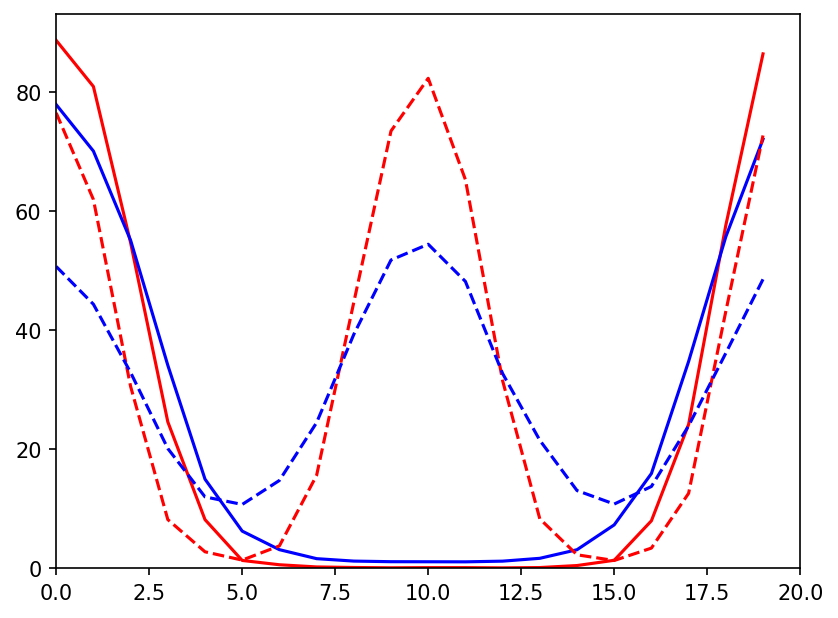

In [20]:
fig,ax = plt.subplots(1,1,dpi=150)

ax.plot(μrEs[0],'r-')
ax.plot(μrIs[0],'b-')
ax.plot(μrEs[1],'r--')
ax.plot(μrIs[1],'b--')
ax.set_xlim(0,Nori)
ax.set_ylim(0,None)

# Investigate Ahmadian, Rubin, & Miller Model with Baselines